# HW 4: MLE/MAP

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
df = pd.read_csv('data/poly_regression_small.csv')
X_train = df['x']
y_train = df['y']

df = pd.read_csv('data/poly_regression_large.csv')
df = df.sample(frac=0.2).reset_index(drop=True)
X_test = df['x']
y_test = df['y']

In [5]:
X_train.shape

(50,)

In [6]:
def Phi(X, K):
    Phi = np.vander(X, K, increasing=True)
    return Phi

print(Phi([2,2,3,4,5], 8))

[[    1     2     4     8    16    32    64   128]
 [    1     2     4     8    16    32    64   128]
 [    1     3     9    27    81   243   729  2187]
 [    1     4    16    64   256  1024  4096 16384]
 [    1     5    25   125   625  3125 15625 78125]]


### Linear System Solvers

In [7]:
def gradient_descent(X, Y, loss, grad_loss, alpha, maxit, tolx, tolf, x0, backtracking=None):
    theta_k = x0
    theta_old = np.inf
    theta_k_history = []
    theta_k_history.append(theta_k)
    grad_norm_0 = np.linalg.norm(grad_loss(X, theta_k, Y), 2)
    grad_norm_history = [grad_norm_0]
    grad_norm_k = grad_norm_0

    f_val_k = loss(X, theta_k, Y)
    f_val_history = [f_val_k]

    k = 0
    while (k < maxit and
           np.linalg.norm(theta_k - theta_old, 2) >= tolx and
           grad_norm_k >= tolf*grad_norm_0):

        if backtracking is not None:
            alpha = backtracking(loss, grad_loss, theta_k, X, Y)

        theta_old = theta_k
        theta_k = theta_k - alpha*grad_loss(X, theta_k, Y)
        theta_k_history.append(theta_k)

        grad_norm_k = np.linalg.norm(grad_loss(X, theta_k, Y), 2)
        grad_norm_history.append(grad_norm_k)

        f_val_k = loss(X, theta_k, Y)
        f_val_history.append(f_val_k)

        k += 1

    return theta_k_history, k, f_val_history, grad_norm_history

In [8]:
def backtracking(f, grad_f, theta, X, Y):
    """
    This function is a simple implementation of the backtracking algorithm for
    the GD (Gradient Descent) method.

    f: function. The function that we want to optimize.
    grad_f: function. The gradient of f(x).
    x: ndarray. The actual iterate x_k.
    """
    alpha = 1
    c = 0.8
    tau = 0.25

    while f(X, theta - alpha * grad_f(X, theta, Y), Y) > f(X, theta, Y) - c * alpha * np.linalg.norm(grad_f(X, theta, Y), 2) ** 2:
        alpha = tau * alpha
        if alpha < 1e-3:
            break
    return alpha

In [9]:
def stochastic_gradient_descent(X, Y, loss, grad_loss, theta0, alpha, batch_size, n_epochs):
    N = X.shape[0]
    idx = np.arange(0, N)

    theta_history = []
    loss_history = []
    grad_norm_history = []
    theta_k = theta0

    for _ in range(n_epochs):
        np.random.shuffle(idx)
        X = X[idx]
        Y = Y[idx]

        grad_loss_vec = []

        for batch_start in range(0, N, batch_size):
            batch_end = min(batch_start + batch_size, N)
            X_batch = X[batch_start:batch_end]
            y_batch = Y[batch_start:batch_end]

            gradient = grad_loss(X_batch, theta_k, y_batch)
            grad_loss_vec.append(np.linalg.norm(gradient, 2))

            theta_k = theta_k - alpha * gradient

        theta_history.append(theta_k)
        loss_history.append(loss(X, theta_k, Y))
        grad_norm_history.append(np.mean(grad_loss_vec))

    return theta_history, loss_history, grad_norm_history

In [10]:
def normal_equation_cholesky(A, b):
    ATA = A.T @ A
    ATb = A.T @ b
    L = np.linalg.cholesky(ATA)
    y = np.linalg.solve(L, ATb)
    x = np.linalg.solve(L.T, y)

    return x

In [11]:
PhiX = Phi([1,2,3,4,5], K=5)

print(PhiX.shape)
PhiX

(5, 5)


array([[  1,   1,   1,   1,   1],
       [  1,   2,   4,   8,  16],
       [  1,   3,   9,  27,  81],
       [  1,   4,  16,  64, 256],
       [  1,   5,  25, 125, 625]])

## MLE

### Performance assessment

In [12]:
def plot_data_and_model(X_test, y_test, theta, K, ax, label=""):
    sort_idx = np.argsort(X_test)
    X_test = X_test[sort_idx]
    y_test = y_test[sort_idx]

    PhiX = Phi(X_test, K)
    y_pred = PhiX @ theta

    if label == "":
        ax.plot(X_test, y_pred, label=f'K={K} model')
    else:
        ax.plot(X_test, y_pred, label=f'{label}')
    ax.set_title(f'Polynomial regression with K={K}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend()
    return y_pred

In [13]:
def MLE_loss(PhiX, theta, Y):
    return (1/2)*np.linalg.norm((PhiX @ theta) - Y, 2)**2

def MLE_grad_loss(PhiX, theta, Y):
    return PhiX.T @ (PhiX @ theta - Y)

def MLE_loss1(X, theta, Y):
    PhiX = Phi(X, len(theta))
    return (1/2)*np.linalg.norm((PhiX @ theta) - Y, 2)**2

def MLE_grad_loss1(X, theta, Y):
    PhiX = Phi(X, len(theta))
    return PhiX.T @ (PhiX @ theta - Y)

def gd_run(X_train, y_train, X_test, y_test, K, epochs, ax, label=""):
    theta_k_history, _, _, _ = gradient_descent(X=Phi(X_train, K), Y=y_train, loss=MLE_loss, grad_loss=MLE_grad_loss,
                    x0=np.zeros(K), maxit=epochs, alpha=1, tolf=1e-6, tolx=1e-6, backtracking=backtracking)
    y_pred = plot_data_and_model(X_test, y_test, theta_k_history[-1], K, ax, label=label)
    return np.mean((y_pred - y_test)**2)

def sgd_run(X_train, y_train, X_test, y_test, K, epochs, ax, label=""):
    theta_k_history, _, _ = stochastic_gradient_descent(X=X_train, Y=y_train, loss=MLE_loss1, grad_loss=MLE_grad_loss1,
                    theta0=np.zeros(K), alpha=0.01, batch_size=5, n_epochs=epochs)
    y_pred = plot_data_and_model(X_test, y_test, theta_k_history[-1], K, ax, label=label)
    return np.mean((y_pred - y_test)**2)

def cholesky_run(X_train, y_train, X_test, y_test, K, ax, label=""):
    theta = normal_equation_cholesky(Phi(X_train, K), y_train)
    y_pred = plot_data_and_model(X_test, y_test, theta, K, ax, label=label)
    return np.mean((y_pred - y_test)**2)


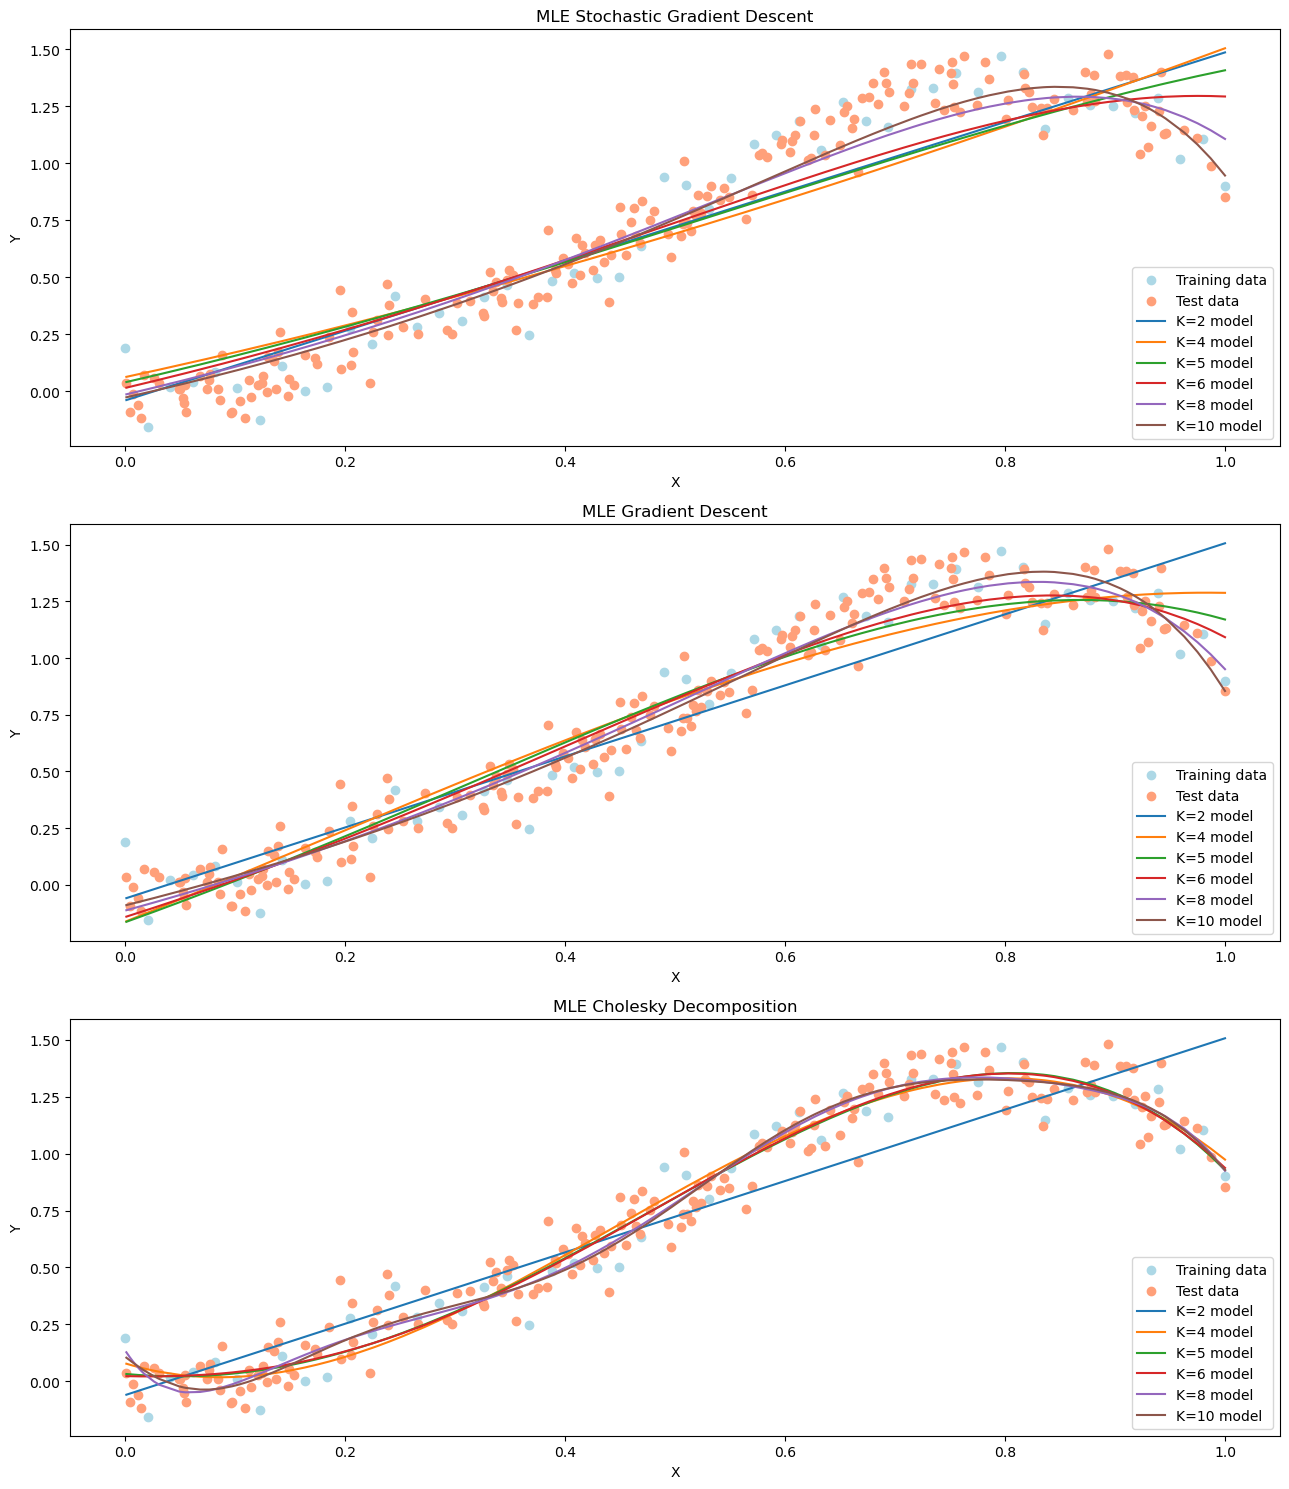

In [14]:

fig, axes = plt.subplots(3, 1, figsize=(13, 15))
K = list(np.arange(2,11,2))
K.extend([5])
K.sort()

mle_errors_gd = []
mle_errors_sgd = []
mle_errors_cho = []

axes[0].scatter(X_train, y_train, color='lightblue', label='Training data')
axes[0].scatter(X_test, y_test, color='lightsalmon', label='Test data')
for k in K:
    errors = sgd_run(X_train, y_train, X_test, y_test, K=k, epochs=100, ax=axes[0])
    mle_errors_sgd.append(errors)
axes[0].set_title('MLE Stochastic Gradient Descent')

axes[1].scatter(X_train, y_train, color='lightblue', label='Training data')
axes[1].scatter(X_test, y_test, color='lightsalmon', label='Test data')
for k in K:
    errors = gd_run(X_train, y_train, X_test, y_test, K=k, epochs=100, ax=axes[1])
    mle_errors_gd.append(errors)
axes[1].set_title('MLE Gradient Descent')

axes[2].scatter(X_train, y_train, color='lightblue', label='Training data')
axes[2].scatter(X_test, y_test, color='lightsalmon', label='Test data')
for k in K:
    errors = cholesky_run(X_train, y_train, X_test, y_test, K=k, ax=axes[2])
    mle_errors_cho.append(errors)
axes[2].set_title('MLE Cholesky Decomposition')

for ax in axes:
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

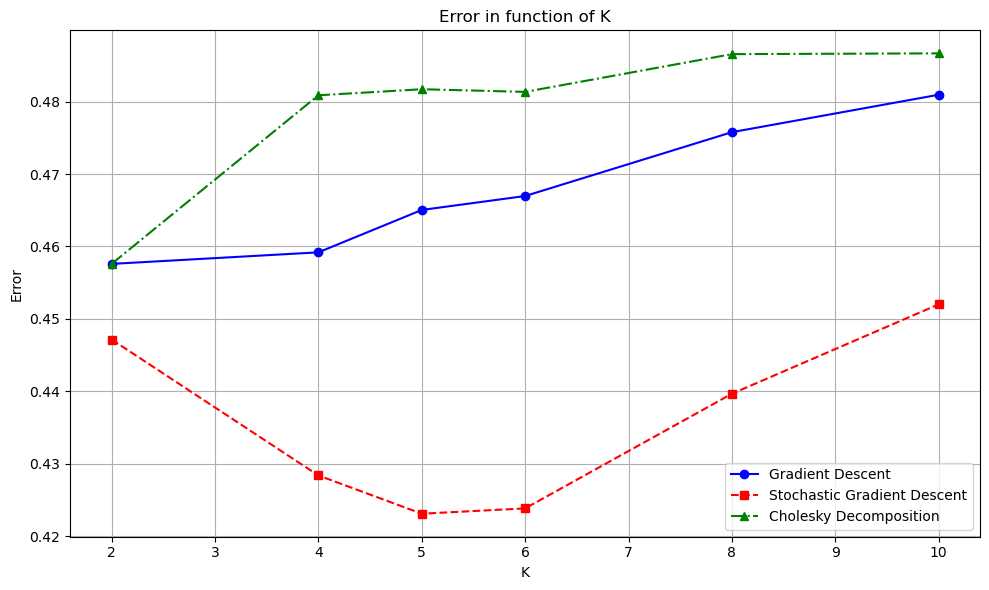

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(K, mle_errors_gd, marker='o', linestyle='-', color='b', label='Gradient Descent')
ax.plot(K, mle_errors_sgd, marker='s', linestyle='--', color='r', label='Stochastic Gradient Descent')
ax.plot(K, mle_errors_cho, marker='^', linestyle='-.', color='g', label='Cholesky Decomposition')

ax.set_title('Error in function of K')
ax.set_xlabel('K')
ax.set_ylabel('Error')

ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

From the plots, we can see how:
- by increasing $K$, the error is increasingly lower, until we reach a minimum. After that, the error becomes increasingly higher.
   - Generally, the errors are comparable, since they are all around ~0.4. However, the results obtained by the SGD are the best, followed by GD and finally Cholesky decomposition.
- In the graphs, the higher the $K$, the more "adherent" to the data-points the functions gets. In this regard, the Cholesky decomposition is the most adherent.

## MAP

In [16]:
lambdas = [0.001, 0.01, 0.1, 1, 10, 100]

In [17]:
def MAP_normal_equation_cholesky(PhiX, Y, lambda_reg):
    to_decompose = PhiX.T @ PhiX + lambda_reg * np.identity(PhiX.shape[1])

    L = np.linalg.cholesky(to_decompose)
    y = np.linalg.solve(L, PhiX.T @ Y)
    theta_map = np.linalg.solve(L.T, y)

    return theta_map

In [18]:
from functools import partial

def MAP_loss(PhiX, theta, Y, lambda_reg):
    return (1/2)*np.linalg.norm((PhiX @ theta) - Y, 2)**2 + (lambda_reg/2)*np.linalg.norm(theta,2)**2

def MAP_grad_loss(PhiX, theta, Y, lambda_reg):
    return PhiX.T @ (PhiX @ theta - Y) + lambda_reg*theta

def MAP_loss1(X, theta, Y, lambda_reg):
    PhiX = Phi(X, len(theta))
    return (1/2)*np.linalg.norm((PhiX @ theta) - Y, 2)**2 + (lambda_reg/2)*np.linalg.norm(theta,2)**2

def MAP_grad_loss1(X, theta, Y, lambda_reg):
    PhiX = Phi(X, len(theta))
    return PhiX.T @ (PhiX @ theta - Y) + lambda_reg*theta

def gd_run_map(X_train, y_train, X_test, y_test, K, epochs, lambda_reg, ax, label=""):
    theta_k_history, _, _, _ = gradient_descent(X=Phi(X_train, K), Y=y_train, 
                    loss=partial(MAP_loss, lambda_reg=lambda_reg),
                    grad_loss=partial(MAP_grad_loss, lambda_reg=lambda_reg),
                    x0=np.zeros(K), maxit=epochs, alpha=1, tolf=1e-6, tolx=1e-6, backtracking=backtracking)
    y_pred = plot_data_and_model(X_test, y_test, theta_k_history[-1], K, ax, label=label)
    return np.mean((y_pred - y_test)**2)

def sgd_run_map(X_train, y_train, X_test, y_test, K, epochs, lambda_reg, ax, label=""):
    theta_k_history, _, _ = stochastic_gradient_descent(X=X_train, Y=y_train,
                    loss=partial(MAP_loss1, lambda_reg=lambda_reg),
                    grad_loss=partial(MAP_grad_loss1, lambda_reg=lambda_reg),
                    theta0=np.zeros(K), alpha=0.01, batch_size=5, n_epochs=epochs)
    y_pred = plot_data_and_model(X_test, y_test, theta_k_history[-1], K, ax, label=label)
    return np.mean((y_pred - y_test)**2)


def cholesky_run_map(X_train, y_train, X_test, y_test, K, lambda_reg, ax, label=""):
    theta = MAP_normal_equation_cholesky(Phi(X_train, K), y_train,lambda_reg=lambda_reg)
    y_pred = plot_data_and_model(X_test, y_test, theta, K, ax, label=label)
    return np.mean((y_pred - y_test)**2)


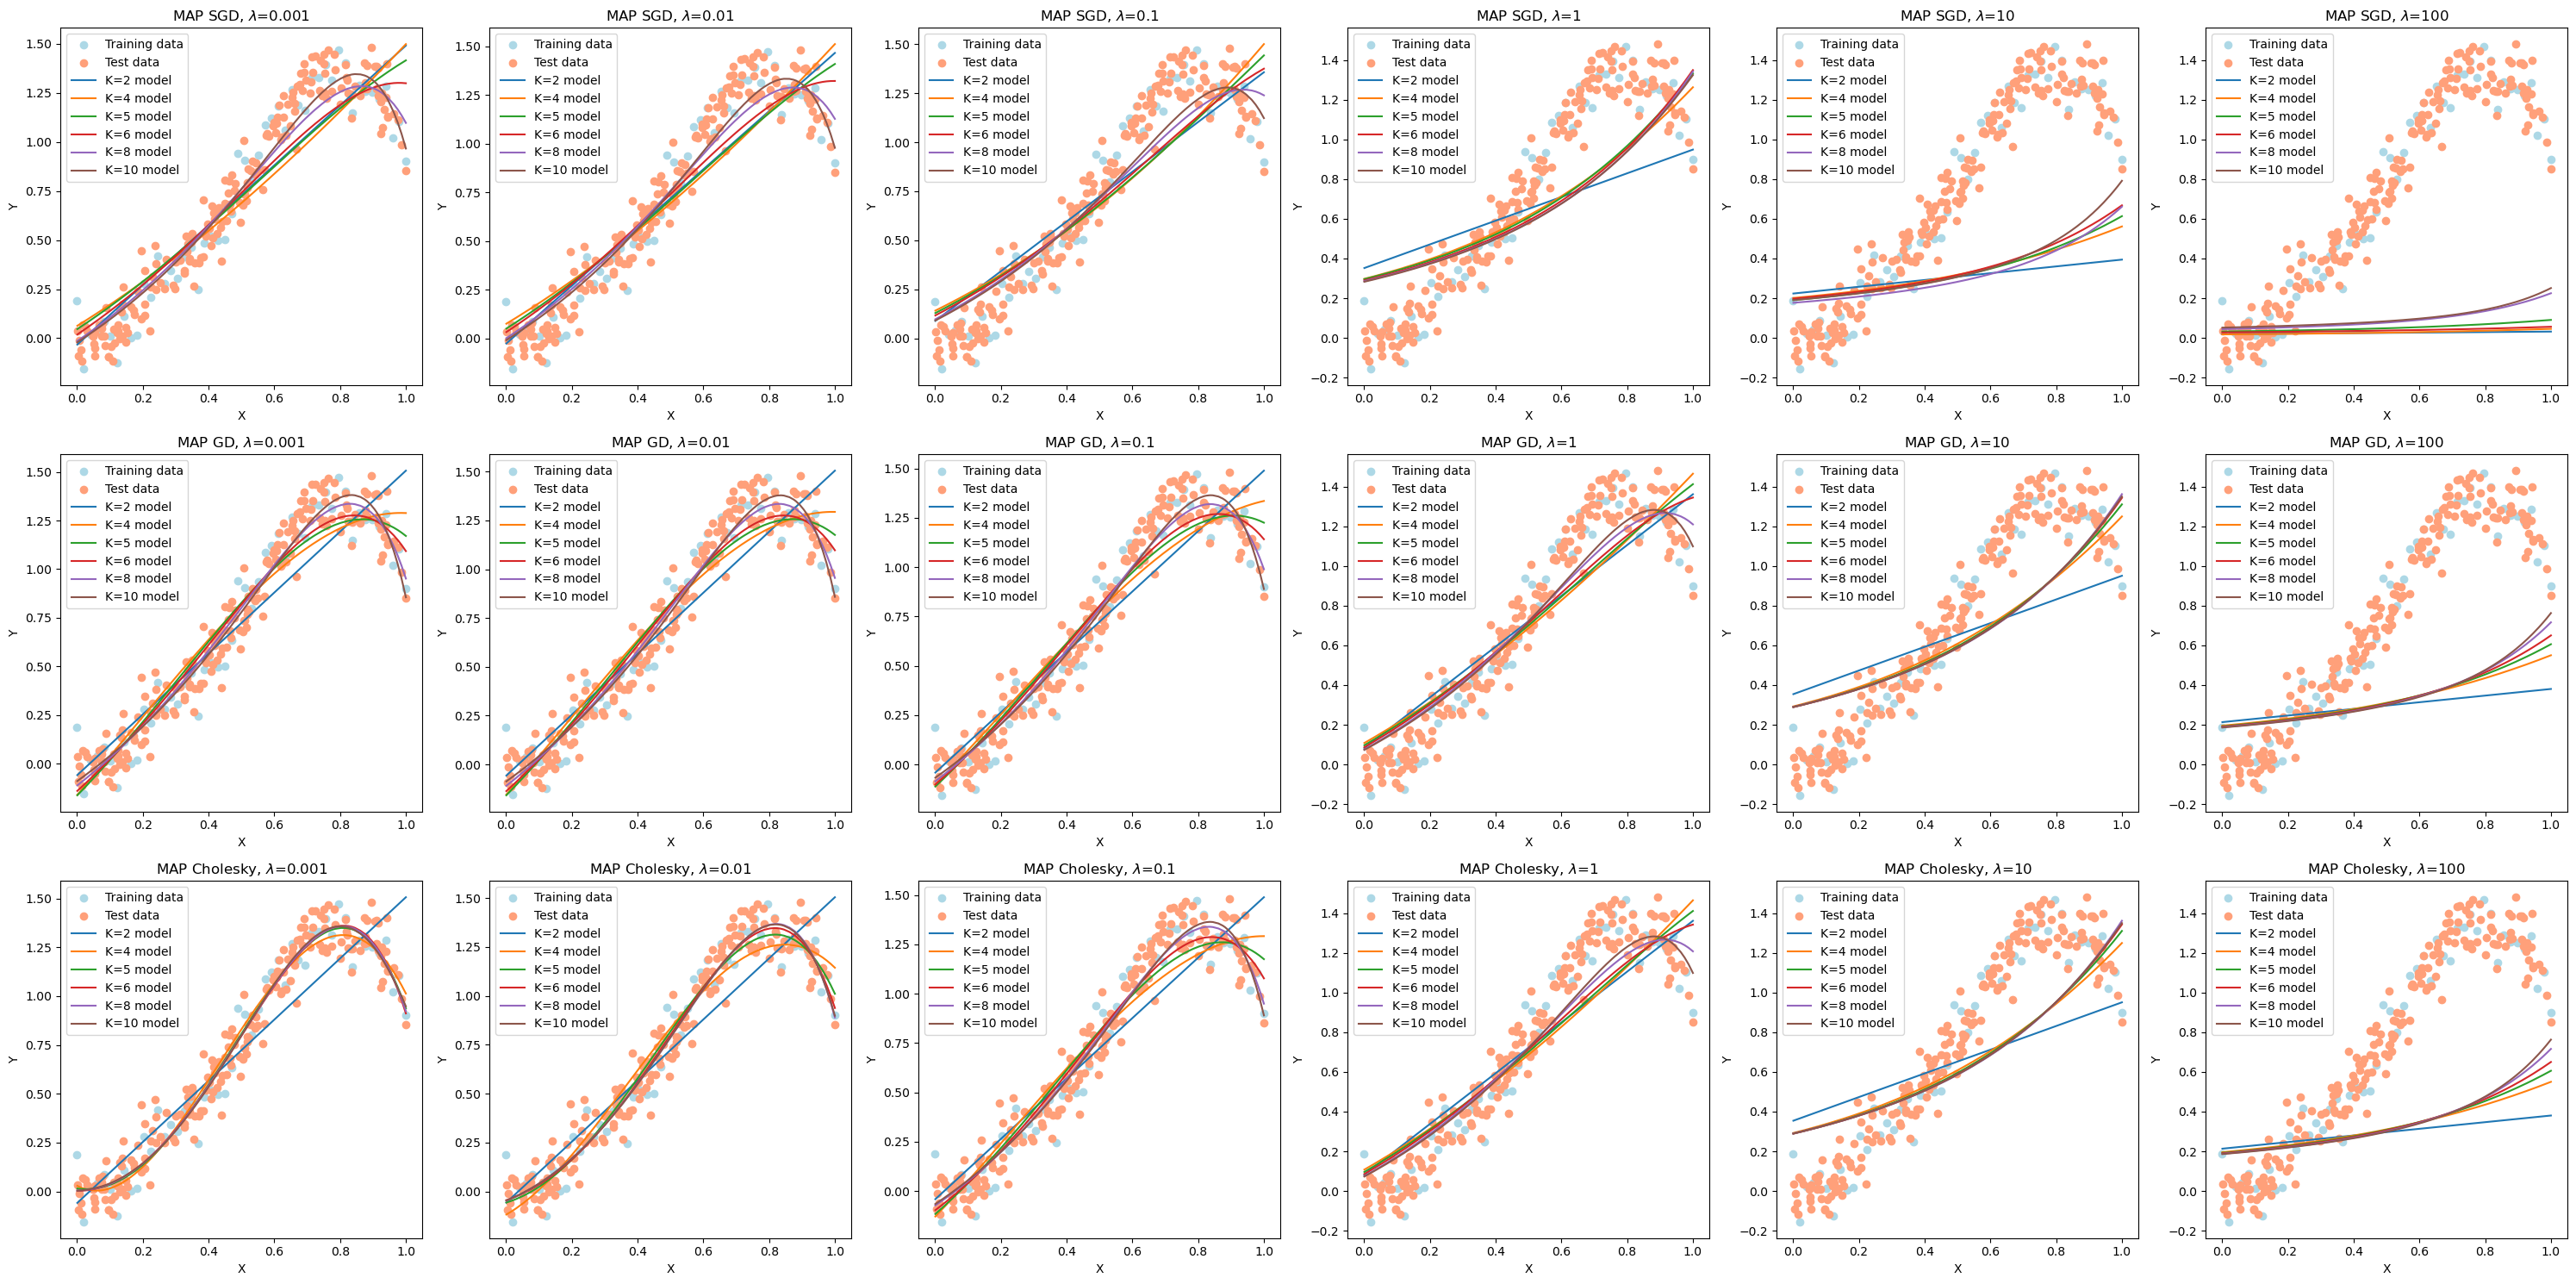

In [19]:
K = list(np.arange(2,11,2))
K.extend([5])
K.sort()

fig, axes = plt.subplots(3, 6, figsize=(30, 15))

errors_gd_s = []
errors_sgd_s = []
errors_cho_s = []

for col, lam in enumerate(lambdas):
    errors_gd = []
    errors_sgd = []
    errors_cho = []
    axes[0, col].scatter(X_train, y_train, color='lightblue', label='Training data')
    axes[0, col].scatter(X_test, y_test, color='lightsalmon', label='Test data')
    for k in K:
        errors = sgd_run_map(X_train, y_train, X_test, y_test, K=k, epochs=100, lambda_reg=lam, ax=axes[0, col])
        errors_gd.append(errors)
    axes[0, col].set_title(rf'MAP SGD, $\lambda$={lam}')
    axes[0, col].set_xlabel('X')
    axes[0, col].set_ylabel('Y')

    axes[1, col].scatter(X_train, y_train, color='lightblue', label='Training data')
    axes[1, col].scatter(X_test, y_test, color='lightsalmon', label='Test data')
    for k in K:
        errors = gd_run_map(X_train, y_train, X_test, y_test, K=k, epochs=100, lambda_reg=lam, ax=axes[1, col])
        errors_sgd.append(errors)
    axes[1, col].set_title(rf'MAP GD, $\lambda$={lam}')
    axes[1, col].set_xlabel('X')
    axes[1, col].set_ylabel('Y')

    axes[2, col].scatter(X_train, y_train, color='lightblue', label='Training data')
    axes[2, col].scatter(X_test, y_test, color='lightsalmon', label='Test data')
    for k in K:
        errors = cholesky_run_map(X_train, y_train, X_test, y_test, K=k, lambda_reg=lam, ax=axes[2, col])
        errors_cho.append(errors)
    axes[2, col].set_title(rf'MAP Cholesky, $\lambda$={lam}')
    axes[2, col].set_xlabel('X')
    axes[2, col].set_ylabel('Y')

    errors_gd_s.append(errors_gd)
    errors_sgd_s.append(errors_sgd)
    errors_cho_s.append(errors_cho)


for ax in axes.flat:
    ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

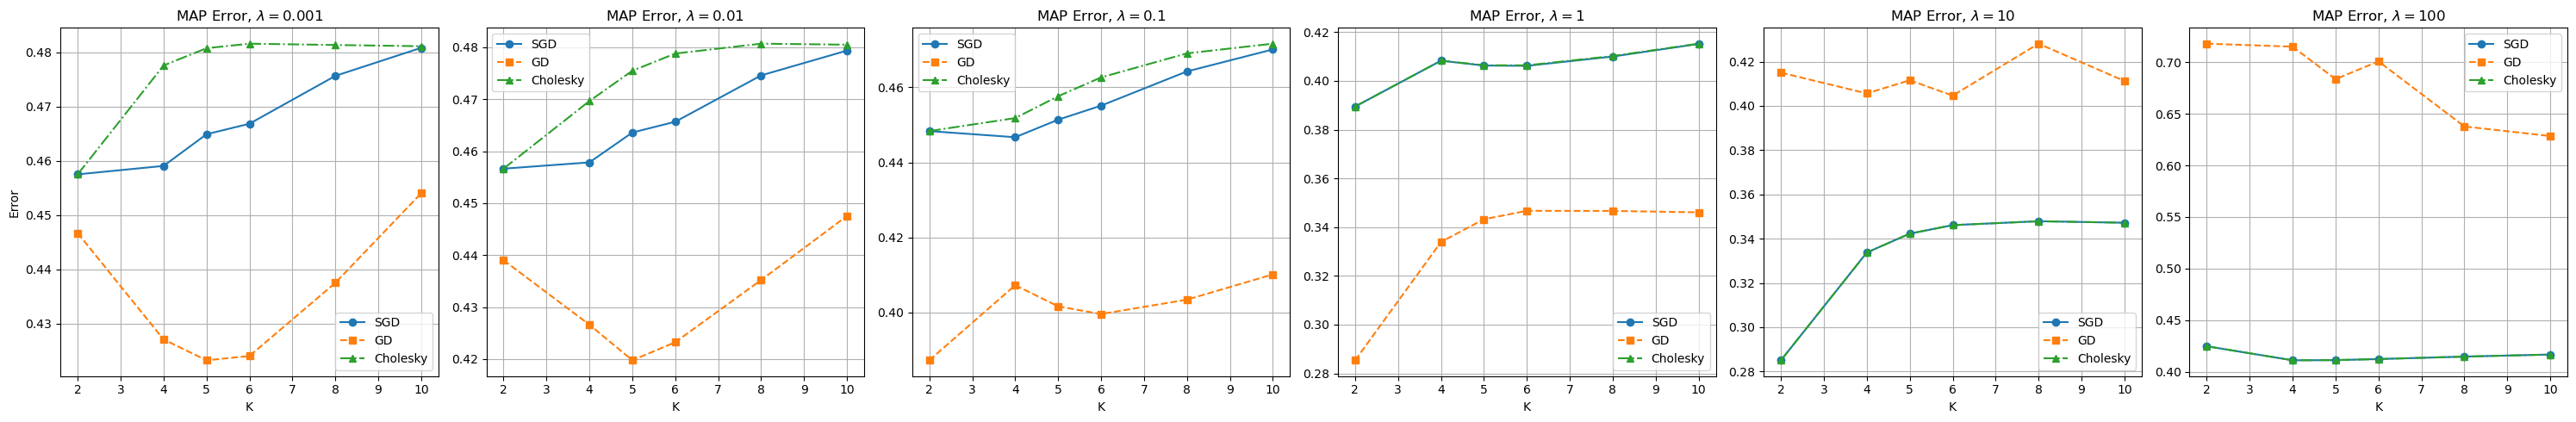

In [20]:
fig, axes = plt.subplots(1, len(lambdas), figsize=(5 * len(lambdas), 5))

for col, lam in enumerate(lambdas):
    ax = axes[col]
    ax.plot(K, errors_sgd_s[col], marker='o', linestyle='-', label='SGD')
    ax.plot(K, errors_gd_s[col], marker='s', linestyle='--', label='GD')
    ax.plot(K, errors_cho_s[col], marker='^', linestyle='-.', label='Cholesky')

    ax.set_title(rf'MAP Error, $\lambda = {lam}$')
    ax.set_xlabel('K')
    if col == 0:
        ax.set_ylabel('Error')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

- When the $\lambda$ is low, the Cholesky decomposition gives the same (or very similar) results after $K$=5 (this is further evidenced by the error graphs)
- When lambda is higher, the result simply does not adhere very well with the data-points.


- In terms of error, the $\lambda$=1 gives generally the best results. Contrary with what we see in the MLE, here the SGD with regularization gives results that are extremely close to the Cholesky decomposition, especially when the right lambda is chosen.
    - When $\lambda$ is too high, the error is also higher.
    - Otherwise, the graphs have a similar structure as the one found in MLE (global minimum and increase of error).

### MAP with varying $\lambda$, $K=8$

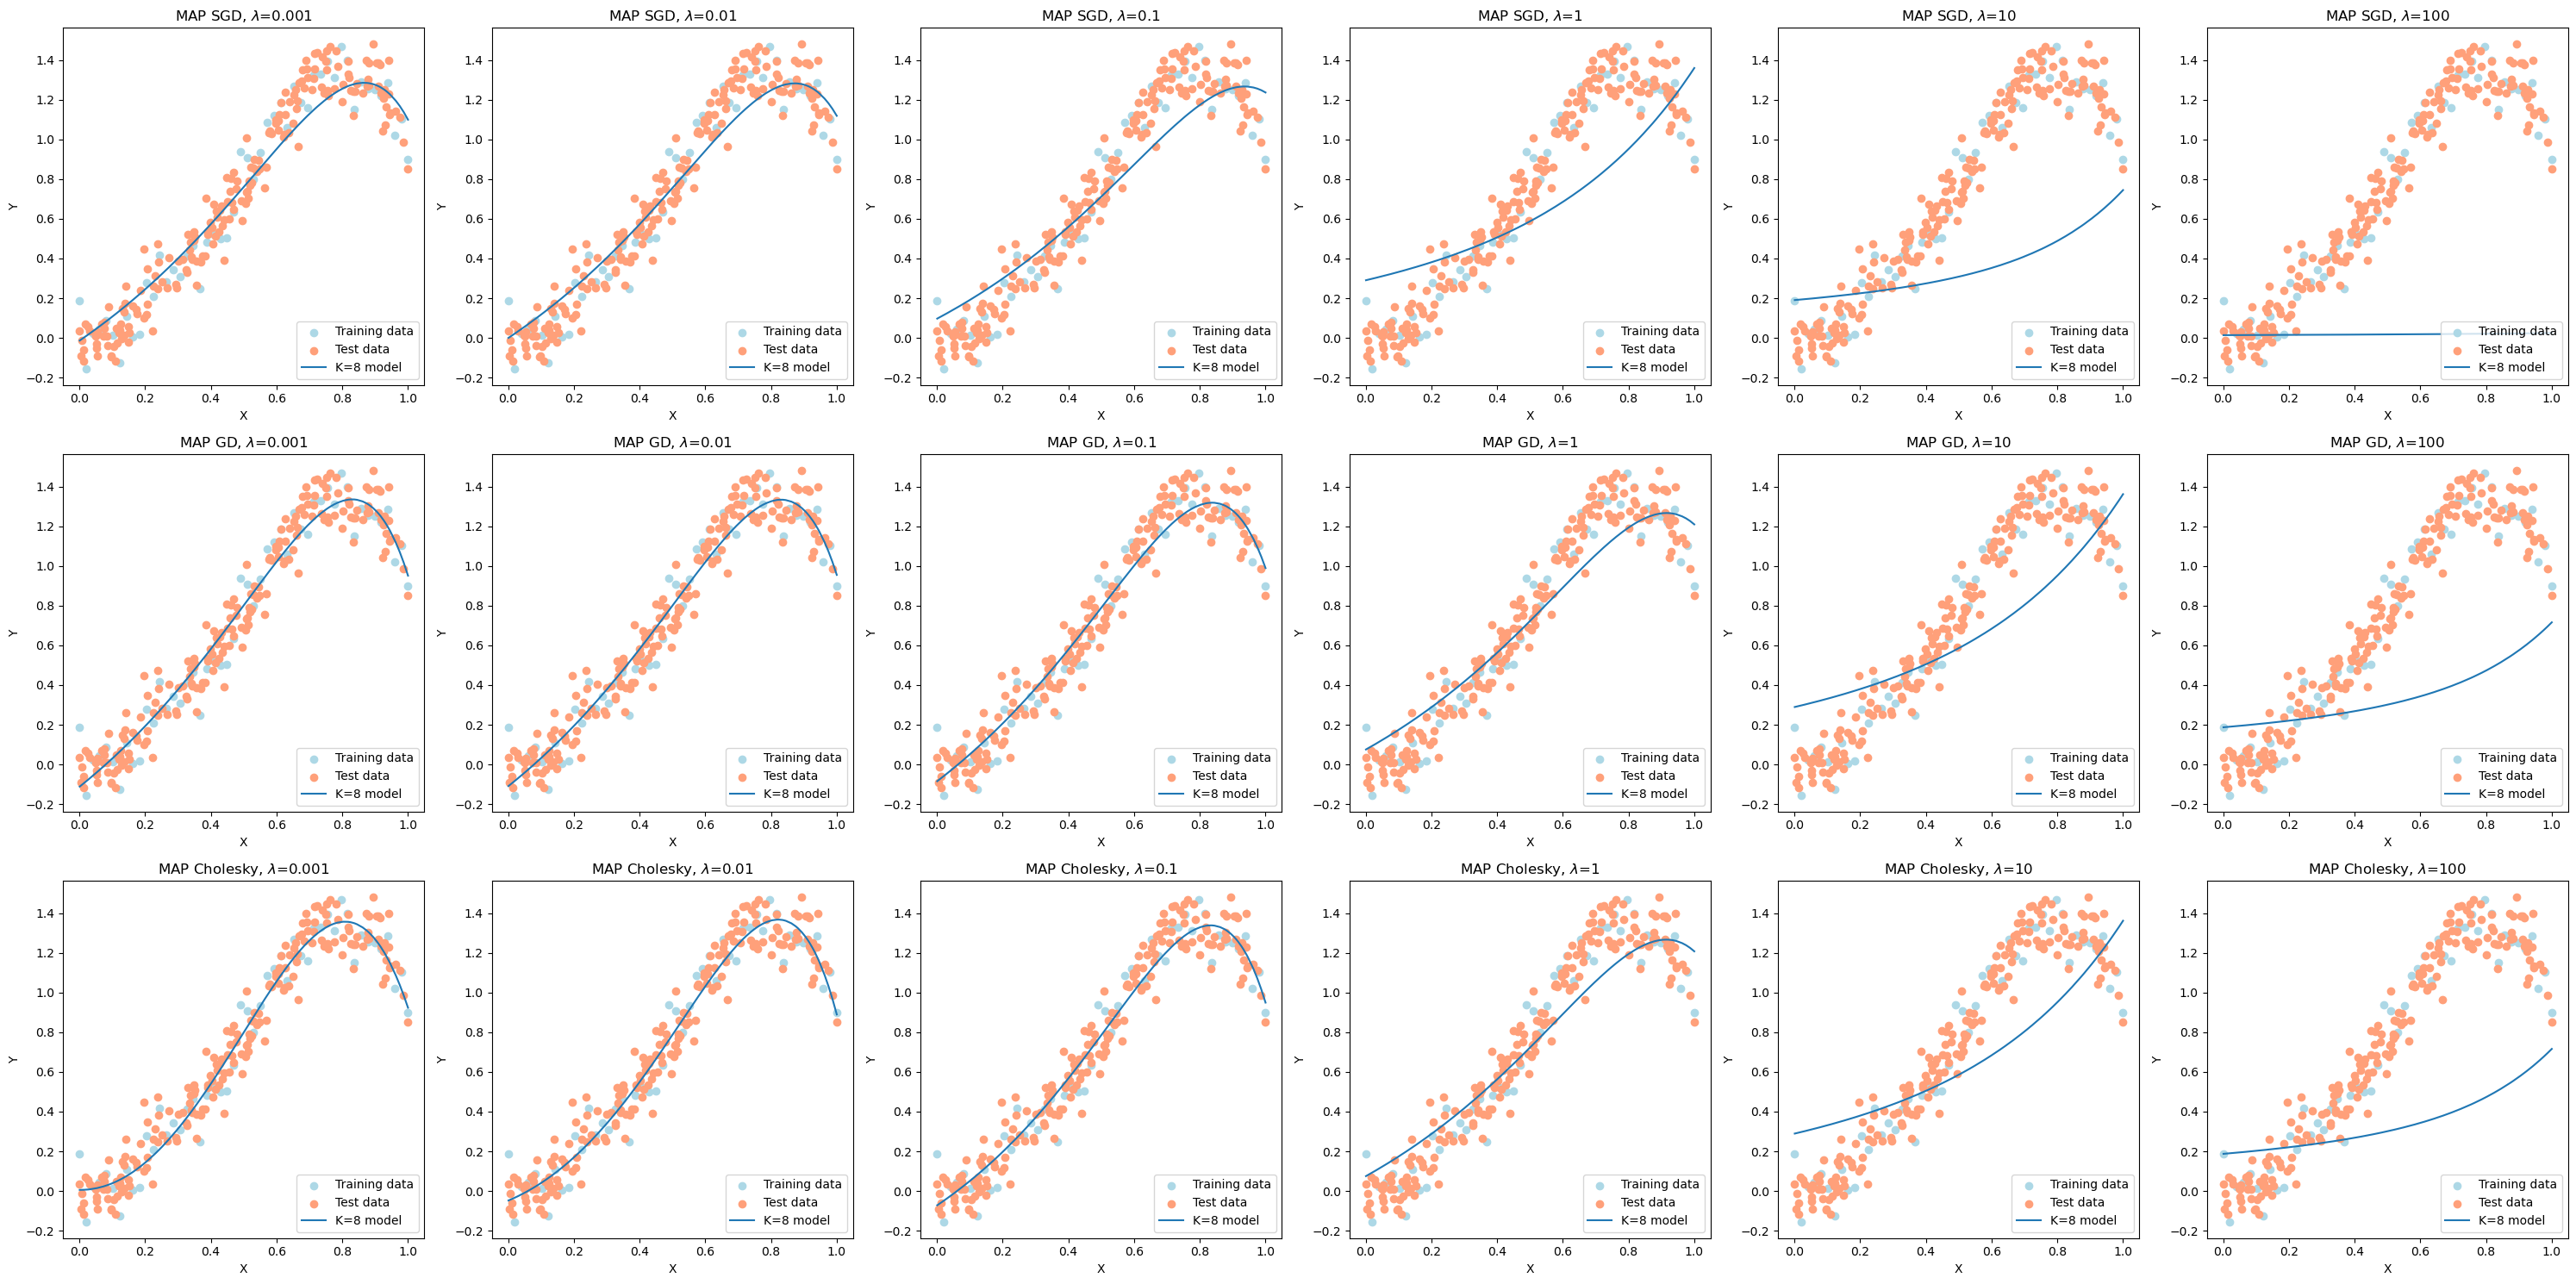

In [21]:
K = [8]
fig, axes = plt.subplots(3, 6, figsize=(30, 15))

for col, lam in enumerate(lambdas):
    axes[0, col].scatter(X_train, y_train, color='lightblue', label='Training data')
    axes[0, col].scatter(X_test, y_test, color='lightsalmon', label='Test data')
    for k in K:
        sgd_run_map(X_train, y_train, X_test, y_test, K=k, epochs=100, lambda_reg=lam, ax=axes[0, col])
    axes[0, col].set_title(rf'MAP SGD, $\lambda$={lam}')
    axes[0, col].set_xlabel('X')
    axes[0, col].set_ylabel('Y')

    axes[1, col].scatter(X_train, y_train, color='lightblue', label='Training data')
    axes[1, col].scatter(X_test, y_test, color='lightsalmon', label='Test data')
    for k in K:
        gd_run_map(X_train, y_train, X_test, y_test, K=k, epochs=100, lambda_reg=lam, ax=axes[1, col])
    axes[1, col].set_title(rf'MAP GD, $\lambda$={lam}')
    axes[1, col].set_xlabel('X')
    axes[1, col].set_ylabel('Y')

    axes[2, col].scatter(X_train, y_train, color='lightblue', label='Training data')
    axes[2, col].scatter(X_test, y_test, color='lightsalmon', label='Test data')
    for k in K:
        cholesky_run_map(X_train, y_train, X_test, y_test, K=k, lambda_reg=lam, ax=axes[2, col])
    axes[2, col].set_title(rf'MAP Cholesky, $\lambda$={lam}')
    axes[2, col].set_xlabel('X')
    axes[2, col].set_ylabel('Y')

for ax in axes.flat:
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

From the plots, we can see how:
- there's more adherence with the training data when $\lambda$ is lower. On the other hand, when $\lambda$ is too high, the plot is simply corrupted.
- the plot of the GD is much different than the one for SGD. On the other hand the Cholesky plot is closer to the GD, and to the data-points in general.

### Comparing $\theta_{MLE}$ and $\theta_{MAP}$ ($K=8$)

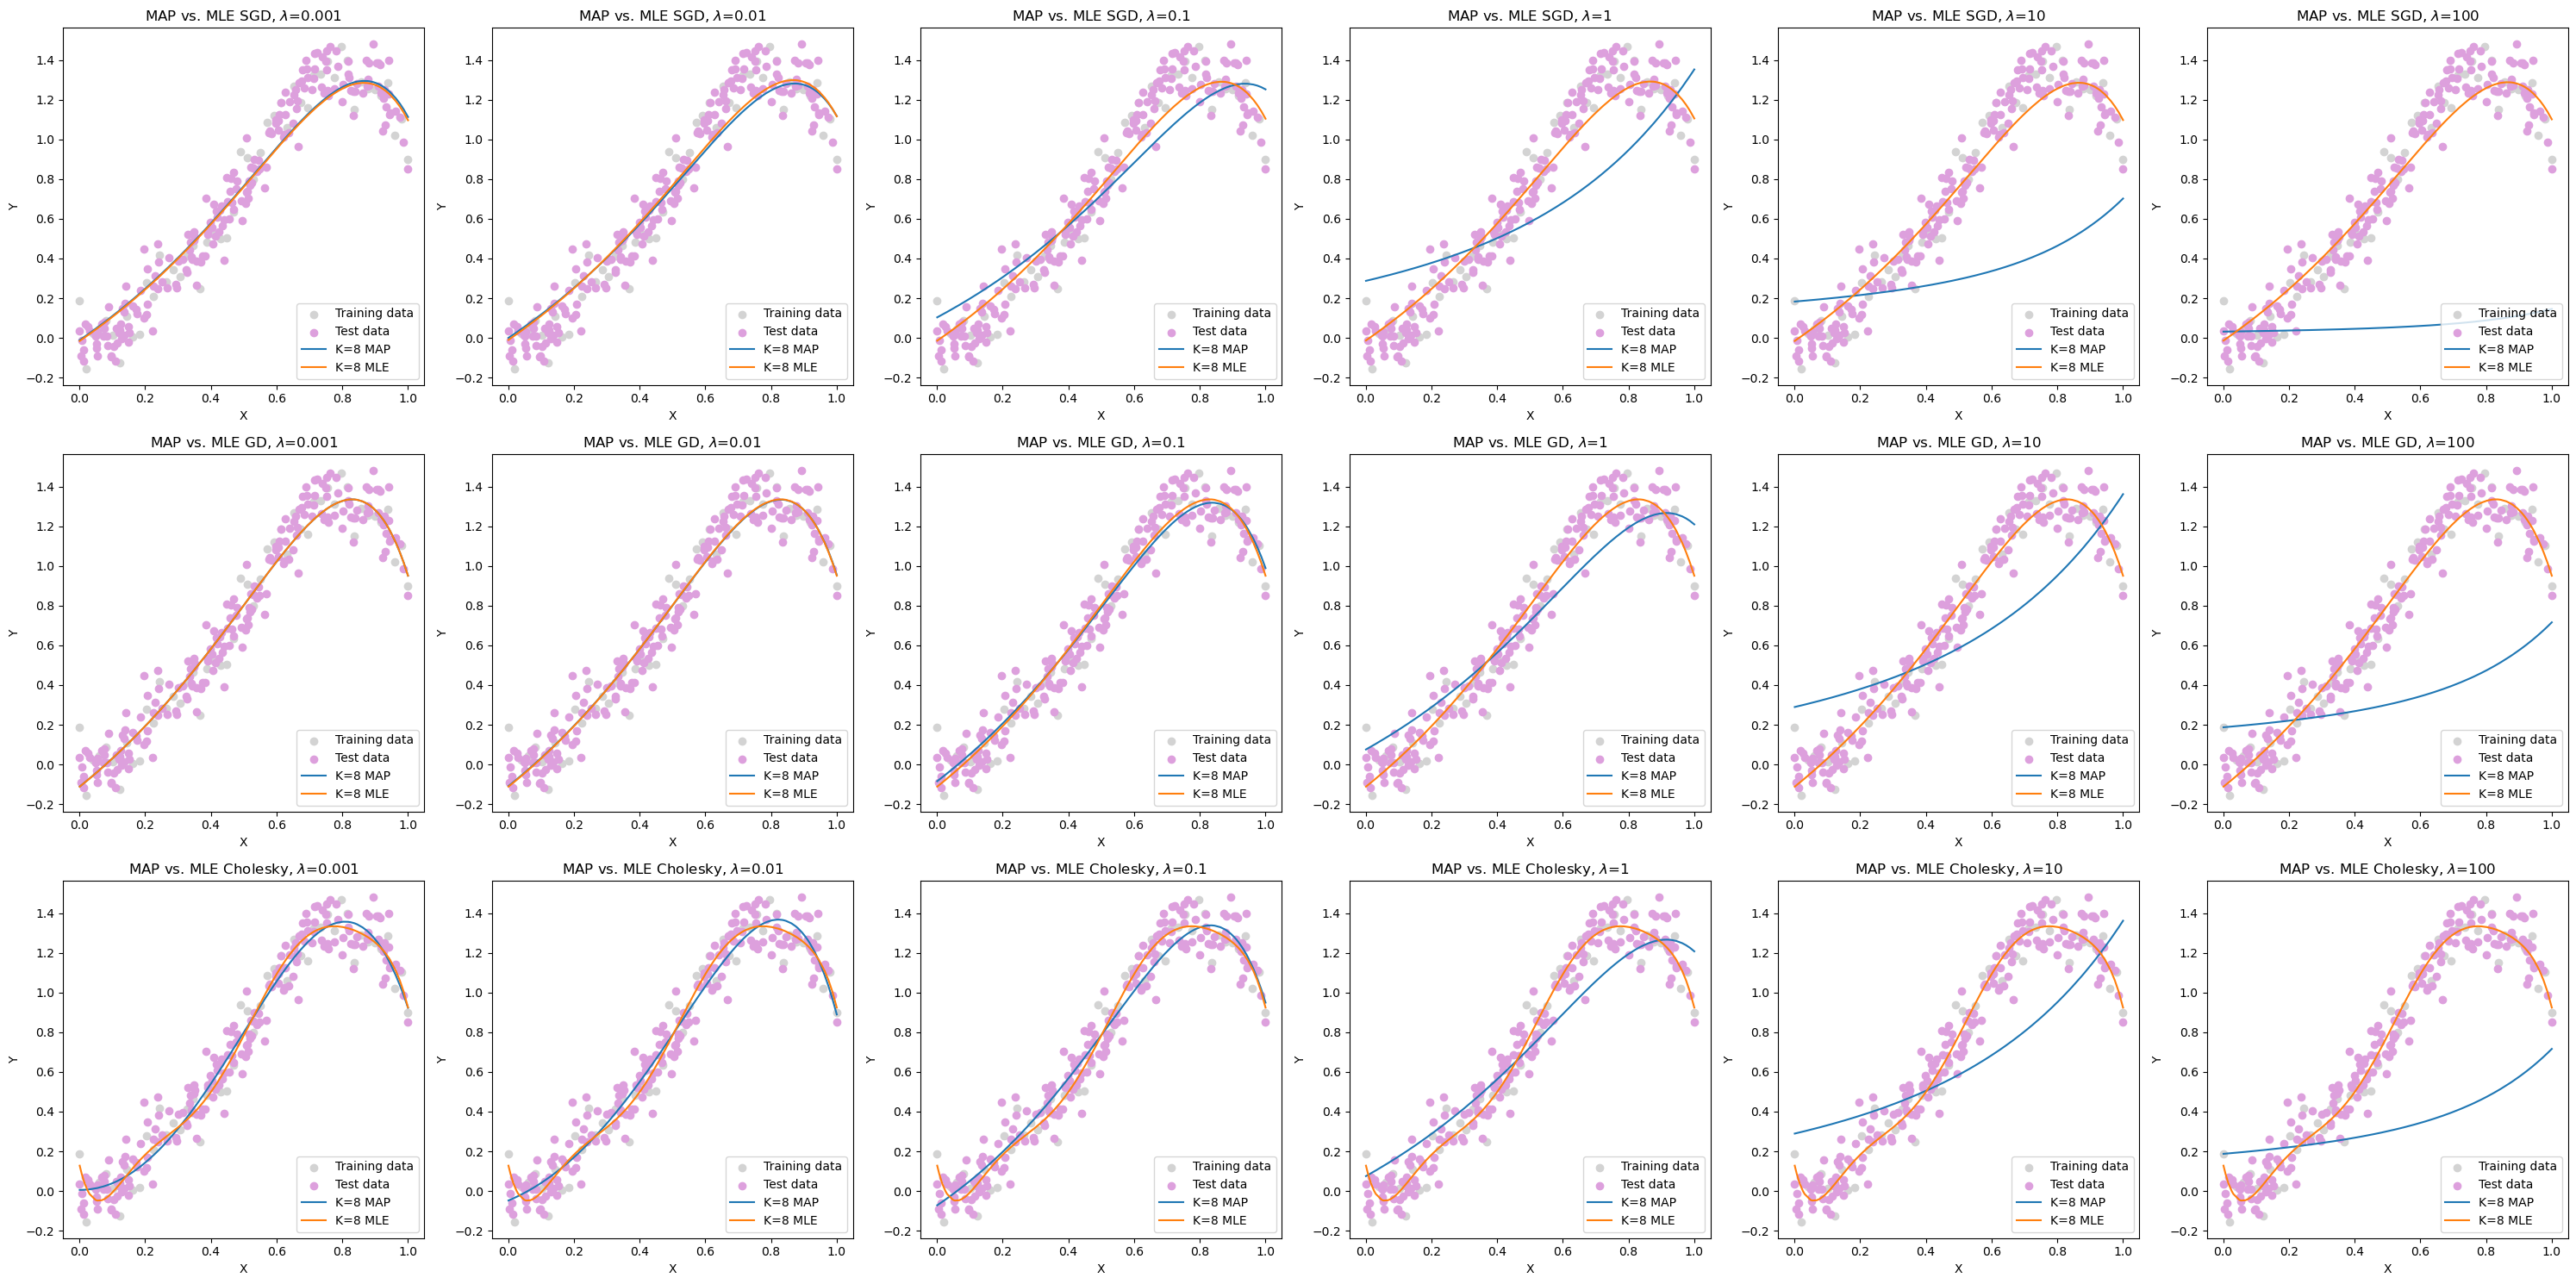

In [22]:
K = [8]
fig, axes = plt.subplots(3, 6, figsize=(30, 15))

map_errors_gd = []
map_errors_sgd = []
map_errors_cho = []

mle_errors_gd = 0
mle_errors_sgd = 0
mle_errors_cho = 0

for col, lam in enumerate(lambdas):
    axes[0, col].scatter(X_train, y_train, color='lightgrey', label='Training data')
    axes[0, col].scatter(X_test, y_test, color='plum', label='Test data')
    for k in K:
        errors = sgd_run_map(X_train, y_train, X_test, y_test, K=k, epochs=100, lambda_reg=lam, ax=axes[0, col], label="K=8 MAP")
        map_errors_sgd.append(errors)
        mle_errors_sgd = sgd_run(X_train, y_train, X_test, y_test, K=k, epochs=100, ax=axes[0, col], label="K=8 MLE")
    axes[0, col].set_title(rf'MAP vs. MLE SGD, $\lambda$={lam}')
    axes[0, col].set_xlabel('X')
    axes[0, col].set_ylabel('Y')

    axes[1, col].scatter(X_train, y_train, color='lightgrey', label='Training data')
    axes[1, col].scatter(X_test, y_test, color='plum', label='Test data')
    for k in K:
        errors = gd_run_map(X_train, y_train, X_test, y_test, K=k, epochs=100, lambda_reg=lam, ax=axes[1, col], label="K=8 MAP")
        map_errors_gd.append(errors)
        mle_errors_gd = gd_run(X_train, y_train, X_test, y_test, K=k, epochs=100, ax=axes[1, col], label="K=8 MLE")
    axes[1, col].set_title(rf'MAP vs. MLE GD, $\lambda$={lam}')
    axes[1, col].set_xlabel('X')
    axes[1, col].set_ylabel('Y')

    axes[2, col].scatter(X_train, y_train, color='lightgrey', label='Training data')
    axes[2, col].scatter(X_test, y_test, color='plum', label='Test data')
    for k in K:
        errors = cholesky_run_map(X_train, y_train, X_test, y_test, K=k, lambda_reg=lam, ax=axes[2, col], label="K=8 MAP")
        map_errors_cho.append(errors)
        mle_errors_cho = cholesky_run(X_train, y_train, X_test, y_test, K=k, ax=axes[2, col], label="K=8 MLE")
    axes[2, col].set_title(rf'MAP vs. MLE Cholesky, $\lambda$={lam}')
    axes[2, col].set_xlabel('X')
    axes[2, col].set_ylabel('Y')

for ax in axes.flat:
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

When using a lower $\lambda$, the graphs are of MAP and MLE are very similar (in SGD and GD). However, MAP still performs better with the right $\lambda$. In addition MLE seems to adhere more to the points.

##### Comparing errors for $\theta_{MLE}$ and $\theta_{MAP}$ ($K=8$)

In [23]:
map_errors_sgd.append(mle_errors_sgd)
map_errors_gd.append(mle_errors_gd)
map_errors_cho.append(mle_errors_cho)

columns = [f'MAP w/ λ={lam}' for lam in lambdas] + ['MLE']

data = {
    'SGD': map_errors_sgd,
    'GD': map_errors_gd,
    'Cholesky': map_errors_cho
}

df = pd.DataFrame(data, index=columns).T
df

,MAP w/ λ=0.001,MAP w/ λ=0.01,MAP w/ λ=0.1,MAP w/ λ=1,MAP w/ λ=10,MAP w/ λ=100,MLE
SGD,0.440149,0.433596,0.404599,0.347318,0.419242,0.673788,0.438641
GD,0.475653,0.474578,0.464247,0.410003,0.347874,0.414812,0.475774
Cholesky,0.481353,0.480682,0.469068,0.410209,0.347874,0.414812,0.486546


When using a lower $\lambda$, the errors are of MAP and MLE are very similar. However, MAP still performs better with the right $\lambda$. 